**Download and unzip the dataset by running the cell below**

This open dataset includes image data based on FDG PET (cerebral metabolic rate of glucose (CMRglc)) of 9 healthy participants, acquired during rest on a Siemens Biograph mMR 3T PET/MR scanner at the TU Munich. Data were acquired across two sessions, one with their eyes open and the other with their eyes closed (mean age = 43 years, std = 7 years; 4 females).

We will compare the metabolic connectivity in these two sessions.

*Acknowledgement:*

*Gabriel Castrillon and Samira Epp and Antonia Bose and Laura Fraticelli and André Hechler and Roman Belenya and Andreas Ranft and Igor Yakushev and Lukas Utz and Lalith Sundar and Josef P Rauschecker and Christine Preibisch and Katarzyna Kurcyus and Valentin Riedl (2023). The energetic costs of the human connectome. OpenNeuro. [Dataset] doi: doi:10.18112/openneuro.ds004513.v1.0.4*

*Castrillon, Gabriel, et al. "An energy costly architecture of neuromodulators for human brain evolution and cognition." Science Advances 9.50 (2023): eadi7632.*


In [2]:
!wget -cO - "https://medunimuenchende-my.sharepoint.com/:u:/g/personal/artem_zatcepin_med_uni-muenchen_de/EZHWksmAhGNFvGDiuGZt-t4BcKkt6r0hXJe5pOgCW4JjOQ?e=je8sWQ&download=1" > molecular_connectivity_tutorial.zip
!unzip molecular_connectivity_tutorial.zip

--2024-04-26 10:29:13--  https://medunimuenchende-my.sharepoint.com/:u:/g/personal/artem_zatcepin_med_uni-muenchen_de/EZHWksmAhGNFvGDiuGZt-t4BcKkt6r0hXJe5pOgCW4JjOQ?e=je8sWQ&download=1
Resolving medunimuenchende-my.sharepoint.com (medunimuenchende-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to medunimuenchende-my.sharepoint.com (medunimuenchende-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/artem_zatcepin_med_uni-muenchen_de/Documents/molecular_connectivity_tutorial.zip?ga=1 [following]
--2024-04-26 10:29:14--  https://medunimuenchende-my.sharepoint.com/personal/artem_zatcepin_med_uni-muenchen_de/Documents/molecular_connectivity_tutorial.zip?ga=1
Reusing existing connection to medunimuenchende-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 6614636 (6.3M) [application/x-zip-compressed]
Saving to: ‘STDOUT’

-                   100%[==========

**Install necessary dependencies and import necessary libraries**

In [3]:
!pip install nilearn  # library for functional connectivity analysis
!pip install pingouin  # library to perform statistical calculations

import numpy as np  # mathematical operations in Python
import pandas as pd  # popular data science package
import matplotlib.pyplot as plt  # Python plotting library
from nilearn import plotting  # medical image plotting

from pathlib import Path  # to work with directories in Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.9 MB/s eta 0:00:00


**Download *molecular connectivity* package from github and import necessary classes and functions**

In [4]:
!git clone https://github.com/artem-zatcepin/molecular-connectivity.git molecularconnectivity

import sys
sys.path.insert(0,'/content/molecularconnectivity')  # we need to add the molecularconnectivity module to the current path

# importing necessary classes and functions from molecularconnectivity
from cohort import Cohort
from atlas import Atlas
import visualization as vis

Cloning into 'molecularconnectivity'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 6), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (21/21), 18.47 KiB | 439.00 KiB/s, done.
Resolving deltas: 100% (6/6), done.


**Read the images of the cohort using *molecular connectivity* package**

In [5]:
root_path = Path('.')  # current directory

# get paths of image data
cohort1_paths = sorted(root_path.glob('eyes_open/*.nii.gz'))
cohort2_paths = sorted(root_path.glob('eyes_closed/*.nii.gz'))

# read the images (performed using nibabel library)
cohort1 = Cohort(cohort1_paths, cohort_name='eyes_open')
cohort2 = Cohort(cohort2_paths, cohort_name='eyes_closed')
cohorts = [cohort1, cohort2]
for cohort in cohorts:
  cohort.load_image_arrays()

# get some info about the cohorts
for cohort in cohorts:
  print(f'Cohort name: {cohort.name}\n')
  print(f'Number of subjects: {len(cohort)}\n')

Cohort name: eyes_open

Number of subjects: 9

Cohort name: eyes_closed

Number of subjects: 9



**Let's have a look at one of the images**

Matrix size (61, 73, 61)
Voxel size [3. 3. 3.] mm


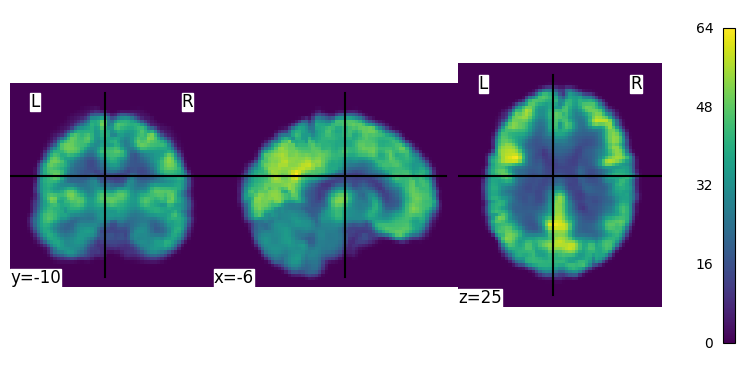

In [6]:
example_img = cohorts[0].nims[0]
plotting.plot_img(example_img, display_mode='ortho', colorbar=True)
# change display_mode to 'mosaic' to see more slices

print(f'Matrix size {example_img.shape}')
print(f'Voxel size {np.abs(np.diag(example_img.affine)[:3])} mm')

The first processing step is **image coregistration**. We adjust for the differences in the patients' positioning in the scanner (rigid registration) and for the individual anatomical differences (deformable registration / warping). This is done to ensure that the brain regions we are about to investigate are located in exactly the same spatial coordinates for every subject.

This step is computationally expensive and has already been done for you.

To perform registration in your studies, you can use a python library **antspy** as well as other software (SPM, PMOD, FSL etc.)

**Scale the images to the mean whole brain uptake to ensure comparability**

Load a binary brain mask:

In [7]:
scaling_mask_path = Path('whole_brain_mask.nii')
scaling_mask = Atlas(scaling_mask_path)  # whole brain mask can be thought of as a brain atlas with only two areas - brain (1) and non-brain (0)

Inspect the loaded mask:

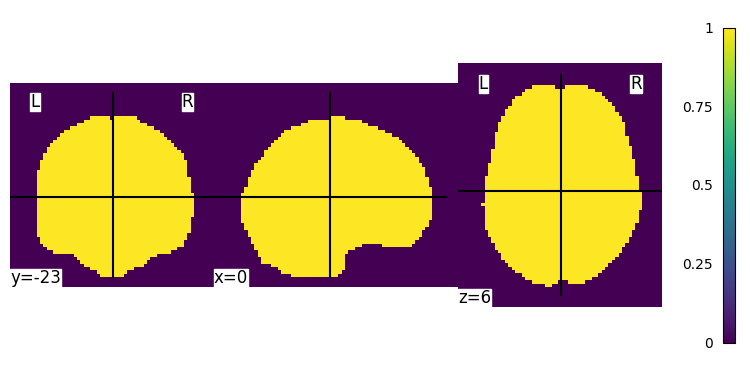

In [8]:
plotting.plot_img(scaling_mask.nim, display_mode='ortho', colorbar=True)

By running the following cell you can confirm that this brain mask contains only voxels with 0 and 1:

In [9]:
print(f'Unique voxel values: {np.unique(scaling_mask.arr)}')

Unique voxel values: [0. 1.]


Apply the mask to scale the images in each cohort:

In [10]:
for cohort in cohorts:
  cohort.scale(atlas=scaling_mask, label=1, feature='mean')  # label=1 means that we use the voxels that equal to 1 in our mask to calculate the mean for scaling
  print(f'Cohort {cohort.name} has been scaled using {scaling_mask.name}')

Cohort eyes_open has been scaled using whole_brain_mask.nii
Cohort eyes_closed has been scaled using whole_brain_mask.nii


Let's have a look at our example image after scaling:

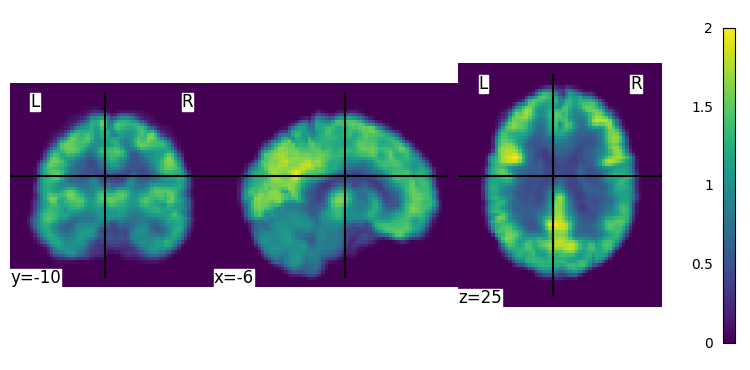

In [11]:
plotting.plot_img(cohorts[0].nims[0], display_mode='ortho', colorbar=True)

Notice the change of range (from 0-64 to 0-2)

**Extract the regional mean uptake using a brain atlas**




To extract regional means for our connectivity analysis, we will use the Schaefer brain atlas

*Schaefer A, Kong R, Gordon EM, Laumann TO, Zuo XN, Holmes AJ, Eickhoff SB, Yeo BTT. Local-Global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral Cortex, 29:3095-3114, 2018*

Load the atlas and display it by running the following cell:

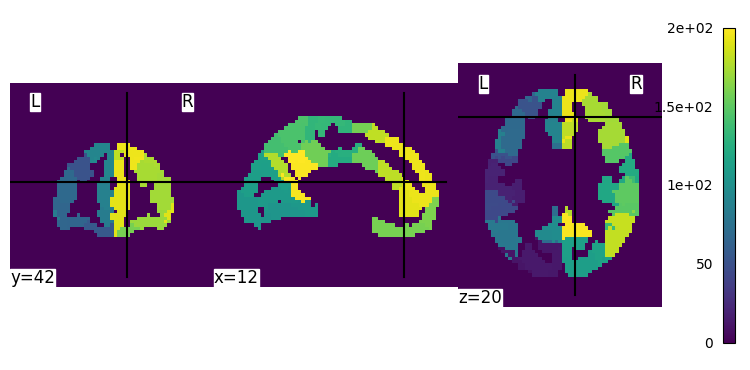

In [12]:
atlas_path = Path('schaefer_brain_atlas')
atlas = Atlas(atlas_path)
plotting.plot_img(atlas.nim, display_mode='ortho', colorbar=True)

Let's find out what individual values are contained in the atlas:

In [13]:
print(f'Unique voxel values: {np.unique(atlas.arr)}')

Unique voxel values: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 

You can see that our atlas has 200 cortical regions (plus 0 for the "non-cortex").

Now, let's extract the means from the 200 atlas regions:

In [14]:
feature_to_extract = 'mean'
for cohort in cohorts:
  cohort.extract_features(atlas=atlas, feature=feature_to_extract, save_path=f'extracted_{feature_to_extract}_schaefer_atlas_cohort_{cohort.name}.xlsx')
  print(f'{feature_to_extract} has been extracted for cohort {cohort.name}')

mean has been extracted for cohort eyes_open
mean has been extracted for cohort eyes_closed


**Inspect extracted features for one of the cohorts**

In [15]:
extracted = pd.read_excel('extracted_mean_schaefer_atlas_cohort_eyes_open.xlsx', index_col=0).T
extracted.head()

,18,20,21,22,26,28,29,30,41,42,...,153,162,163,164,168,185,186,187,188,189
sub-s003_ses-open_task-rest_space-MNI152NLin6ASym_res-3mm_desc-CMRglc_pet.nii,1.203476,1.219917,1.211546,1.193505,1.116766,1.144447,1.125507,1.192956,1.286703,1.275628,...,1.043801,0.692697,0.874490,0.841261,0.995092,0.935048,1.083119,1.080568,1.223078,1.219573
sub-s007_ses-open_task-rest_space-MNI152NLin6ASym_res-3mm_desc-CMRglc_pet.nii,1.222091,1.064926,1.206401,1.181905,1.165477,1.220479,1.139186,1.144068,1.422134,1.260726,...,1.129547,0.804892,0.885567,0.850875,0.901585,0.925372,1.134304,1.087696,1.208051,1.149984
sub-s012_ses-open_task-rest_space-MNI152NLin6ASym_res-3mm_desc-CMRglc_pet.nii,1.178077,1.063009,1.276944,1.260909,1.139157,1.134213,0.983825,1.105949,1.171529,1.211091,...,0.995334,0.768737,0.746055,0.760460,1.065576,0.932105,1.039957,1.001165,1.182264,1.225927
sub-s014_ses-open_task-rest_space-MNI152NLin6ASym_res-3mm_desc-CMRglc_pet.nii,1.193317,1.083360,1.187242,1.248089,1.007930,1.077957,0.941703,1.037043,1.242131,1.199126,...,1.140915,0.750828,0.836515,0.928332,1.112599,0.924107,1.107254,1.086719,1.314367,1.386447
sub-s017_ses-open_task-rest_space-MNI152NLin6ASym_res-3mm_desc-CMRglc_pet.nii,1.232755,1.260185,1.353963,1.243839,1.049563,1.045304,1.205371,1.195973,1.309738,1.167080,...,1.036756,0.760052,0.990432,0.929278,0.956504,0.946222,1.156480,1.185368,1.260813,1.285760


The columns are the individual regions (numbers from 1 to 200), and the rows are the individual study participants.

You can have a look at a Person's correlation coefficient for an example region pair, e.g., region 45 and 178:

Text(0, 0.5, 'Region 178')

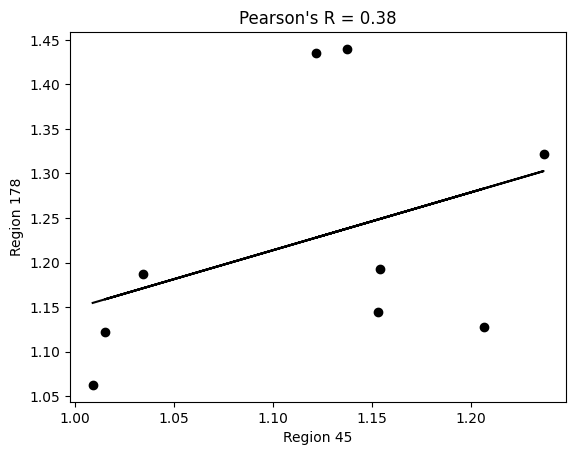

In [16]:
corrs = extracted.corr()
example_r = corrs.loc[45, 178]

x = extracted[45]
y = extracted[178]

coef = np.polyfit(x, y, 1)
lin_fit = np.poly1d(coef)
plt.plot(x, y, 'ko', x, lin_fit(x), 'k-')
plt.title(f"Pearson's R = {example_r:.2f}")
plt.xlabel('Region 45')
plt.ylabel('Region 178')

**Calculate connectivity (based on Pearson's correlation coefficient) - for each region pair**

In [17]:
for cohort in cohorts:
  print(f'Calculating connectivity for cohort {cohort.name}')
  cohort.calculate_connectivity(kind='correlation',
                                fisher_transf=True,
                                n_bootstrap_samples=1000,
                                random_state=0,
                                name=cohort.name)
print('Calculation finished')

Calculating connectivity for cohort eyes_open


/content/molecularconnectivity/connectivity.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_valid_long['abs_value'] = self.df_valid_long['value'].abs()
/content/molecularconnectivity/connectivity.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_valid_long['network_name'] = [self.name] * len(self.df_valid_long)


Calculating connectivity for cohort eyes_closed
Calculation finished


**Inspect the connectivity matrices**

Notice, we performed Fisher's R to Z transformation (parameter fisher_transf=True), that's why the values range from -inf to inf instead of -1 to 1. In practice though, the Z-values are rarely above 2, so we set the range to [-2, 2]

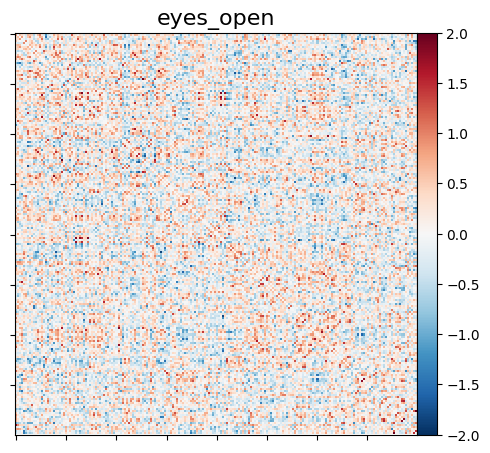

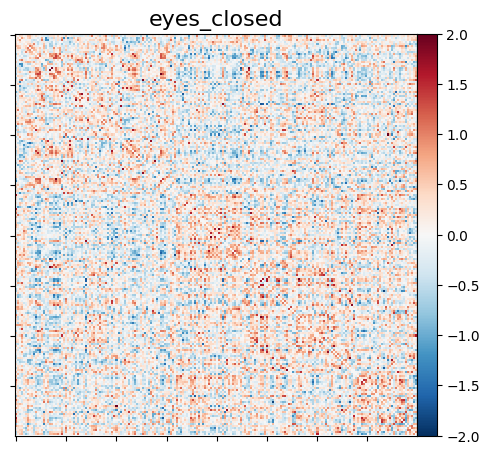

In [18]:
for cohort in cohorts:
  plotting.plot_matrix(cohort.connectivity.matrix,
                      figure=(5, 5),
                      vmin=-2.0,
                      vmax=2.0,
                      title=cohort.name)

**Explore the distributions of the Fisher-transformed correlation coefficent in both cohorts**

Running this cell might take around 2 minutes

Absolute median Z value in cohort Cohort eyes_open, n=9 = 0.309
Absolute median Z value in cohort Cohort eyes_closed, n=9 = 0.314


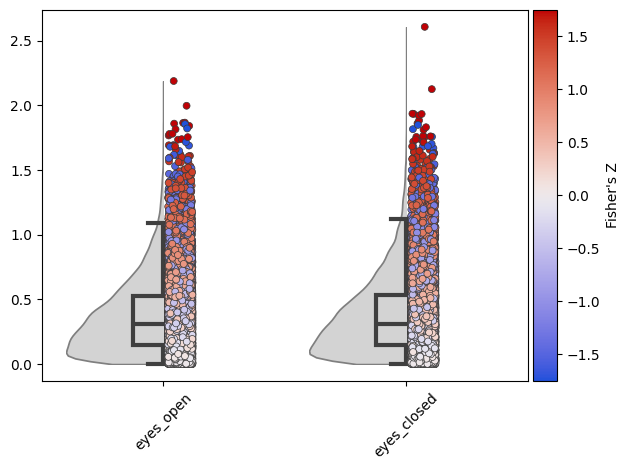

In [19]:
vis.plot_distributions(list_of_data=[cohorts[0].connectivity.network_nonthr, cohorts[1].connectivity.network_nonthr],
                       hue_vmin=-1.75,
                       hue_vmax=1.75,
                       xlabels=[cohorts[0].name, cohorts[1].name],
                       cbar_label="Fisher's Z",
                       save_path='/content/distributions.png',
                       save_stats=True,
                       )
for cohort in cohorts:
  network = cohort.connectivity.network_nonthr
  network.compute_distribution_params()
  print(f'Absolute median Z value in cohort {cohort} = {network.abs_median:.3f}')

Let's inspect the statistics (nonparametric t-test, since the distributions are not normal):

In [20]:
stats = pd.read_excel('distributions.xlsx', index_col=0)
stats.head()

,A,B,Paired,Parametric,W-val,alternative,p-unc,hedges
Contrast,,,,,,,,
network_name,eyes_closed,eyes_open,True,False,96153148.5,two-sided,0.000428,0.035724


**Threshold the connectivity matrices to get the connections**

We will set a threshold to the connections' p-value (p<0.001) to ensure significance, as well as filter by connection magnitude (abs(z)>0.5)

In [21]:
for cohort in cohorts:
  print(f'Applying p-threshold to the connectivity matrix of cohort {cohort.name}')
  cohort.connectivity.threshold_connectivity(method='CI', p=0.001)
  print(f'Applying matrix value threshold to the connectivity matrix of cohort {cohort.name}\n')
  cohort.connectivity.threshold_connectivity(method='matrix_threshold', matrix_thr=0.5)

Applying p-threshold to the connectivity matrix of cohort eyes_open
Applying matrix value threshold to the connectivity matrix of cohort eyes_open

Applying p-threshold to the connectivity matrix of cohort eyes_closed
Applying matrix value threshold to the connectivity matrix of cohort eyes_closed



**Inspect the thresholded connectivity matrices**

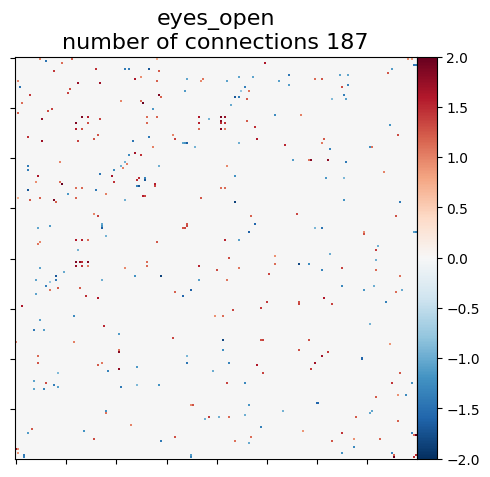

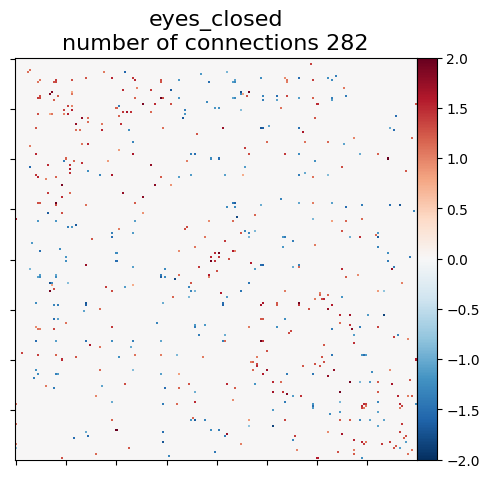

In [22]:
for cohort in cohorts:
  plotting.plot_matrix(cohort.connectivity.network.matrix,
                      figure=(5, 5),
                      vmin=-2.0,
                      vmax=2.0,
                      title=f'{cohort.name}\nnumber of connections {cohort.connectivity.network.n_connect}')

**Plot connections in on a 3D template**

We will use our binary brain mask as a 3D template

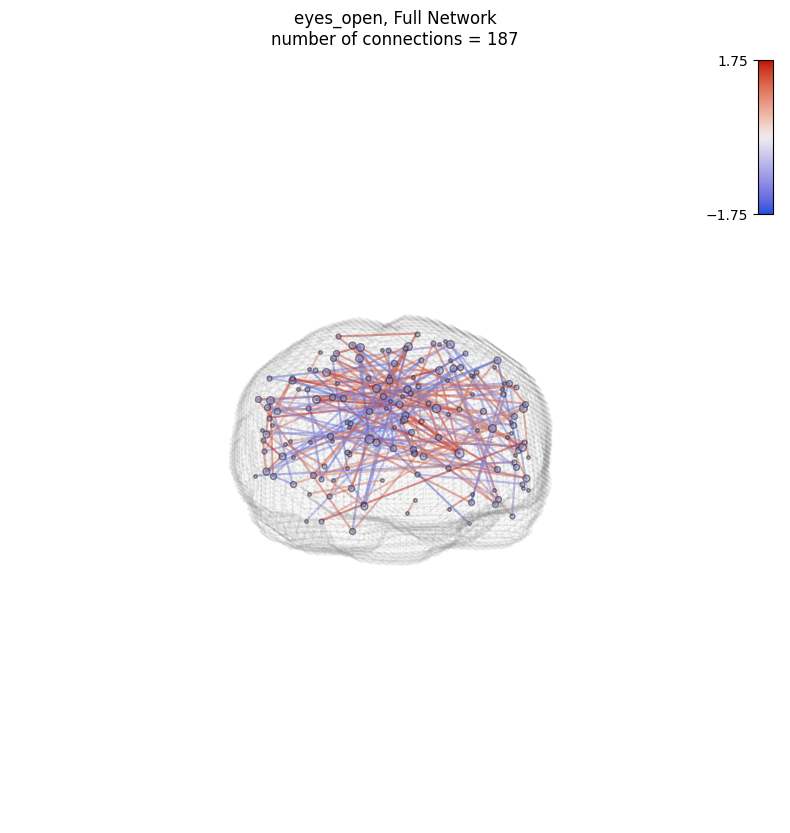

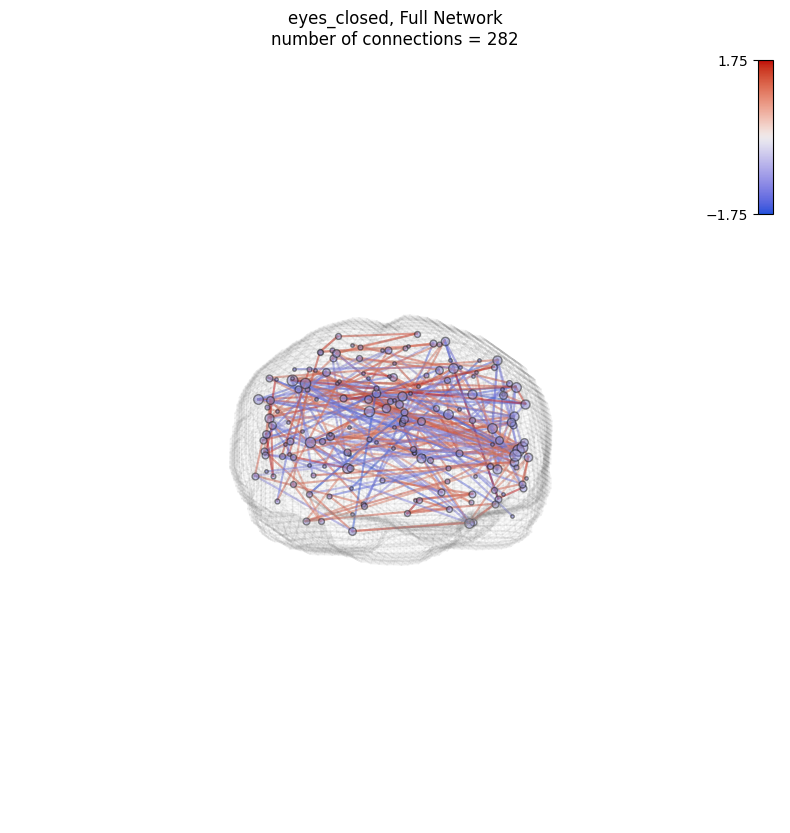

In [24]:
for cohort in cohorts:
  network = cohort.connectivity.network
  vis.plot3d_connectivity_on_template(network=network,
                                      template_nim=scaling_mask.nim,
                                      azim=-75,
                                      elev=-10,
                                      template_alpha=0.03,
                                      vmin=-1.75,
                                      vmax=1.75,
                                      #template_edge_color='white',
                                      #template_face_color='grey',
                                      title=f'{cohort.name}, {network.name}\nnumber of connections = {network.n_connect}',
                                      atlas=atlas,)

The study participants seem to have higher metabolic connectivity when their eyes were closed. However, one should treat these results with caution, since 9 subjects might not be enough for a robust analysis.

**Investigate a subnetwork**

As an example, we will plot the regions belonging to the temporal and parietal lobes (often relevant in dementia studies):

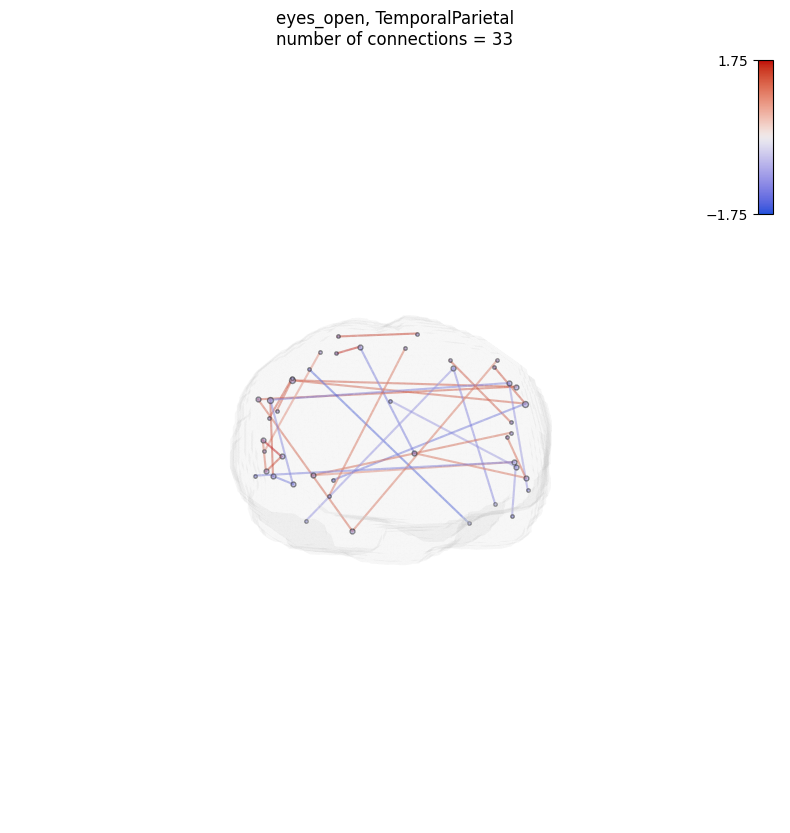

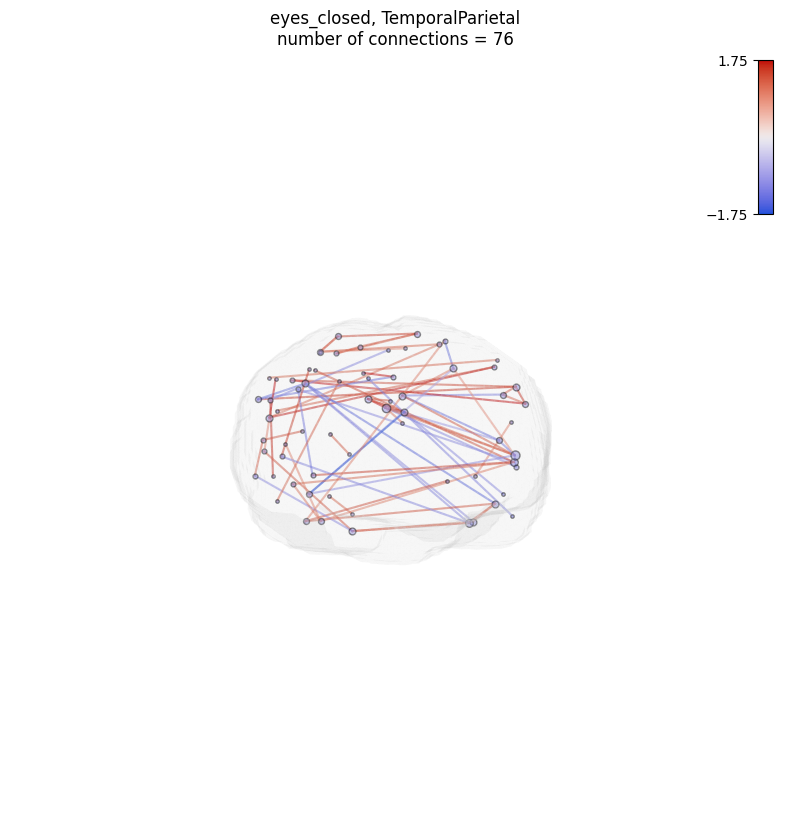

In [26]:
for cohort in cohorts:
  cohort.connectivity.evaluate_subnetworks(subnet_dict=atlas.networks)
  network = cohort.connectivity.subnetworks['TemporalParietal']
  vis.plot3d_connectivity_on_template(network=network,
                                      template_nim=scaling_mask.nim,
                                      azim=-75,
                                      elev=-10,
                                      template_alpha=0.03,
                                      vmin=-1.75,
                                      vmax=1.75,
                                      template_edge_color='white',
                                      template_face_color='grey',
                                      title=f'{cohort.name}, {network.name}\nnumber of connections = {network.n_connect}',
                                      atlas=atlas,)